## Hepsiburada(Turkish Amazon) Comments - Positive and Negative Seperator

- We have a dataset for product review comments.

- We want to understand is review positive or negative with comments. 

>For this case we will use NLP techniques like Tokenizer and Sequence. 

>For model building we can use Tensorflow or PyTorch. 

>I want use GRU( RNN ) for build layers . 

<img src="img/Sent-analysis-diag.png">

# Text

### Importing

In [14]:
import numpy as np # for building arrays

import pandas as pd # for looking dataset


In [15]:
from tensorflow.python.keras.models import Sequential # for building keras models
from tensorflow.python.keras.layers import Dense, GRU, Embedding , CuDNNGRU # for building model layer ( I will use CuDNNGRU but If you don't have a Nvidia GPU or you don't install CUDA can use classic GRU layer.)
from tensorflow.keras.optimizers import Adam # Adam Optimizer for model optimizing
from tensorflow.python.keras.preprocessing.text import Tokenizer # Tokenizer for text transformation to tokens
from tensorflow.python.keras.preprocessing.sequence import pad_sequences # for fill with 0 to outlier length sentences. (in this case outlier length is 59)
from tensorflow.python.keras.models import load_model

<hr>

## Data Importing and Analysis

We need to look at data for understand how distribute data.

In [16]:
data = pd.read_csv('data\hepsiburada.csv')

In [17]:
data.sample(5)

,Rating,Review
233149,1,Ürün gayet iyi her bilgisayarın ihtiyacı olan ...
64924,1,Hem fiyatı uygun hemde kaliteli ve kurulumu ço...
32462,1,Iphone 7 yi anlatmaya gerek yok... Satıcı ürün...
12963,1,bu cep telefonu gerçekten çok güzel. hem kendi...
210524,1,mukemmel ürün. teşekkürler.


> So we have one column data of Rating. 
<br>Rating is emotion  we get from comments.

    1 - Positive

    0 - Negative 
    
<br>

> And other column gives comments.
<br> We will preprocess on comments before building model.


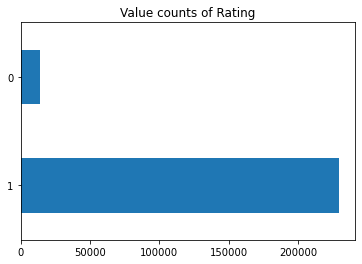

In [18]:
count_rating = data['Rating'].value_counts()

(count_rating .plot.barh()
 .set_title("Value counts of Rating"));

> We have too much Positive comments but we don't need make any preprocessing because we have power of Neural Network.

<hr>

### Dependent and Independent values split (X and Y)

* We assign Rating variable to target (Y/Dependent)

* We assign Review variable to X (Independent) for predict target

In [19]:
Y = data['Rating'].values.tolist()

In [20]:
x = data['Review'].values.tolist()

In [21]:
Y[0:5]

[1, 1, 1, 1, 1]

In [22]:
x[0:2]

['3 yıldır tık demedi. :)', '3 yıldır kullanıyorum müthiş ']

<hr>

## Train-Test split

### We assign cutoff value for train-test split. 

In [23]:
cutoff = int(len(x) * 0.80)

### Train test split with cutoff value (%80)

In [24]:
x_train , x_test = x[:cutoff], x[cutoff:]

In [25]:
y_train, y_test = Y[:cutoff], Y[cutoff:]

In [26]:
x_train[4]

'Günlük kullanımınızı çok çok iyi karsılıyor kısaca mükemmel'

In [27]:
y_train[4]

1

<hr>

# Tokenizer

We need to transform texts to tokens for prediction model(GRU) can understand 

### Exclude and tokenize less than 10000 repetitive words

In [28]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [29]:
tokenizer.fit_on_texts(x)

In [30]:
#tokenizer.word_index 

In [31]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [32]:
x_train[800]

'ürünü alalı 3 hafta kadar oldu. aralıksız kullanıyorum bilgisyarım sürekli açık durur ve ben günde yaklaşık 12 saat başındayım mousesu çok kullanırım. şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim.'

In [33]:
print(x_train_tokens[800])

[19, 341, 52, 194, 30, 54, 7992, 55, 209, 603, 7887, 3, 36, 114, 164, 479, 85, 1, 1682, 782, 30, 2, 380, 326, 3, 1, 81, 132, 562, 9, 10]


In [34]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

...

...

...

<hr>

#### In order for us to give these comments to the RNN algorithm, all of them must have the same number of words, namely the number (vector) of tokens.

##### This is how we can find the number of words with a list builder.

In [35]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]

In [36]:
num_tokens= np.array(num_tokens)

### Mean of word number

In [37]:
np.mean(num_tokens)

20.744703220162876

## Longest comment

In [38]:
np.max(num_tokens)

295

In [39]:
np.argmax(num_tokens)

21941

In [40]:
x_train[np.argmax(num_tokens)]

'Özellikle bu kısma yazıyorum iyice okuyunuz,cihazın hızı çok iyi.Isınma normal boyutlarda.Kamerası elinizi sabit tutarsanız ve gündüz çok net gece ise çok net çekmez.Görüntülü konuşma özelliği yok ancak uygulama ile olur,anten çekimi gayet iyi.Parmak izi okuyucusu gayet hızlı bazen tuşu silmenizi istiyor ve okuyamıyor kirden vs...Ön kamera da tatmin edici,çekim esnasında ekran beyaz ışık vererek flaş görevi görür.Batarya bana 1 hafta gidiyor sık kullanımda ise 2-3 gün gidiyor.Hızlı şarj 1 saatte doluyor , şekilleri ele oturuyor ve şık bir görüntü var.Telefonu aldığım gün gittim ve ilk girdiğim yerden ekran koruyucu ve kılıf buldum.Kulaklık sesi çok net ve yüksek ancak kendi hoparlörü biraz zayıf sesi.Ekrana bakarken açık kalma özelliği yok.Diğer akıllı cihaz özellikleri %90 ı bu cihazda mevcut.Güç tasarrufu 2 ayrı modu var ve çok başarılı çalışıyor.4gb ram var genelde yarısı boş kalıyor.Bir de yeni cihazların çoğu titreşimi az ve sesi de az çıkıyor.Bu cihaz da içine dahil...Bu cihazla

<hr>

## Setting a threshold value

<img src="https://miro.medium.com/max/24000/1*IZ2II2HYKeoMrdLU5jW6Dw.png">

We can use 95 rule for assign a threshold value. It will be equal %95 of comments.

In [41]:
max_tokens = int(np.mean(num_tokens)  + 2* np.std(num_tokens))

In [42]:
max_tokens

59

In [43]:
np.sum(num_tokens < max_tokens)/ len(num_tokens)

0.9597982726686571

### Filling sentences of more than 59 words with 0

In [44]:
x_train_pad = pad_sequences(x_train_tokens, maxlen= max_tokens)

In [45]:
x_test_pad = pad_sequences(x_test_tokens, maxlen= max_tokens)

### Let's look at the diferrence

In [46]:
np.array(x_train_tokens[800])

array([  19,  341,   52,  194,   30,   54, 7992,   55,  209,  603, 7887,
          3,   36,  114,  164,  479,   85,    1, 1682,  782,   30,    2,
        380,  326,    3,    1,   81,  132,  562,    9,   10])

In [47]:
x_train_pad[800]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   19,  341,   52,  194,   30,
         54, 7992,   55,  209,  603, 7887,    3,   36,  114,  164,  479,
         85,    1, 1682,  782,   30,    2,  380,  326,    3,    1,   81,
        132,  562,    9,   10])

<hr>

#### Deleting unnecessary and incorrect words by writing a function

In [48]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [49]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [50]:
x_train[800]

'ürünü alalı 3 hafta kadar oldu. aralıksız kullanıyorum bilgisyarım sürekli açık durur ve ben günde yaklaşık 12 saat başındayım mousesu çok kullanırım. şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim.'

In [51]:
tokens_to_string(x_train_tokens[800])

'ürünü alalı 3 hafta kadar oldu aralıksız kullanıyorum sürekli açık durur ve ben günde yaklaşık 12 saat çok kullanırım şimdiye kadar bir problem yaşamadım ve çok memnunum almak isteyenlere tavsiye ederim'

<hr>

# Recurrent Neural Networks (Gated recurrent unit)

#### Why we use GRU ? 

#### The GRU model is based on the LSTM model. It is simpler and more effective than LSTM. It eliminates most problems such as weight burst in RNN algorithm.

<img src="https://media-exp1.licdn.com/dms/image/C5612AQH5Im8XrvLmYQ/article-cover_image-shrink_600_2000/0?e=1605139200&v=beta&t=rKahwYS-7dw1Fkl_r5TvoPbVBrCSNWnLy-BggRPpl1s">

In [52]:
model = Sequential()

# Embedding

In [53]:
embedding_size = 50

In [54]:
model.add(Embedding(input_dim= num_words,
                   output_dim= embedding_size,
                   input_length= max_tokens,
                   name= 'embedding_layer'))

## 3-layer GRU

I will use CuDNN because I have Nvidia GPU. If you want work on CPU, can write only GRU instead of CuDNNGRU on model building.

In [55]:
model.add(CuDNNGRU(units=16,return_sequences=True)) 
model.add(CuDNNGRU(units=8,return_sequences=True))
model.add(CuDNNGRU(units=4))
model.add(Dense(1, activation='sigmoid'))

In [56]:
optimizer = Adam(lr=1e-3)

In [57]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

<hr>

### Overview of Model

In [58]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 59, 50)            500000    
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, 59, 16)            3264      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 59, 8)             624       
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 504,061
Trainable params: 504,061
Non-trainable params: 0
_________________________________________________________________


## Model Fitting with 5 epochs

> In Tensorflow 2.0 , we use only numpy arrays.

In [ ]:
x_train_pad = np.array(x_train_pad)

In [60]:
y_train = np.array(y_train)

In [61]:
model.fit(x_train_pad,y_train,epochs=5,batch_size=256)

Epoch 1/5
761/761 [==============================] - 15s 19ms/step - loss: 0.1775 - accuracy: 0.9539
Epoch 2/5
761/761 [==============================] - 14s 19ms/step - loss: 0.0918 - accuracy: 0.9711
Epoch 3/5
761/761 [==============================] - 15s 19ms/step - loss: 0.0688 - accuracy: 0.9790
Epoch 4/5
761/761 [==============================] - 14s 19ms/step - loss: 0.0524 - accuracy: 0.9850
Epoch 5/5
761/761 [==============================] - 14s 19ms/step - loss: 0.0409 - accuracy: 0.9892


<hr>

## Evaluate Model 

In [62]:
x_test_pad = np.array(x_test_pad)
y_test = np.array(y_test)

In [63]:
result = model.evaluate(x_test_pad,y_test)

1522/1522 [==============================] - 7s 5ms/step - loss: 0.1587 - accuracy: 0.9537


<hr>

## Wrong Predictions

> With the help of this function, we can browse the incorrectly predicted data according to the test data.

In [64]:
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

In [65]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

In [66]:
cls_true = np.array(y_test[0:1000])

In [67]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]
len(incorrect)

53

In [68]:
idx = incorrect[0]
idx

5

In [69]:
text = x_test[idx]
text

'Ürün güzel ama teslimat çok geç yapıldı.'

In [70]:
y_pred[idx]

0.9511686

In [71]:
cls_true[idx]

0

<hr>

### Testing with new data from us

In [81]:
def prediction(text):
    token = tokenizer.texts_to_sequences([text])
    tok_pad = pad_sequences(token, maxlen= max_tokens)
    
    result= model.predict(tok_pad)[0][0]
    
    if result <0.5:
        return "Negative"
    else:
        return "Positive"

In [82]:
prediction('berbat bir ürün')

'Negative'